## **Modeling**

In [4]:
# https://github.com/uber/orbit/blob/dev/docs/tutorials/build_your_own_model.ipynb
!pip install git+https://github.com/uber/orbit.git@dev

  Cloning https://github.com/uber/orbit.git (to revision dev) to /tmp/pip-req-build-xdqjn79o
  Running command git clone -q https://github.com/uber/orbit.git /tmp/pip-req-build-xdqjn79o
     |████████████████████████████████| 10.3 MB 5.2 MB/s 
     |████████████████████████████████| 678 kB 50.2 MB/s 
     |████████████████████████████████| 9.5 MB 16.4 MB/s 
  Created wheel for orbit-ml: filename=orbit_ml-1.1.0.dev0-py3-none-any.whl size=458398 sha256=f2b20fa77f8b4ac25aa40fe7990a252c91d5cabfdafcea2ac454a21bf0ef532c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ma0rbg48/wheels/ab/f9/65/8ecb7988589bb3949bff645bfcebec19620df3af8ac1c693dc
Successfully built orbit-ml
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled st

In [5]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 99 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbit-ml 1.1.0.dev0 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [6]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from copy import deepcopy
import matplotlib.pyplot as plt
import pickle

import orbit
from orbit.template.model_template import ModelTemplate
from orbit.forecaster import SVIForecaster
from orbit.estimators.pyro_estimator import PyroEstimatorVI

from orbit.utils.simulation import make_regression
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [89]:
CompleteData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data_Eafit/CompleteData.csv", index_col=0)
CompleteData.index = pd.to_datetime(CompleteData.index)
df = CompleteData.copy()
df = df.reset_index()
df = df.rename(columns={"index": "Date"})
df = df.sort_values('Date')
df = df.set_index("Date")
df_g = df.groupby(pd.Grouper(freq='M')).mean() 
df_g = df_g.reset_index()
df = df.reset_index()
df_g

,Date,Abejorral,Abrego,Acacias,Acevedo,Agrado,Agua De Dios,Aguachica,Aguadas,Aguazul,Agustín Codazzi,Aipe,Albania,Alcalá,Altamira,Alvarado,Amagá,Amalfi,Ambalema,Anapoima,Andalucía,Andes,Angostura,Anolaima,Anserma,Ansermanuevo,Anzoátegui,Apartadó,Apia,Apulo,Aquitania,Aracataca,Aranzázu,Arauca,Arboletes,Argelia,Ariguaní,Arjona,Armenia,Armero,...,Zipacón,Zipaquirá,Zona Bananera,Ísnos,Casabianca,Castilla La Nueva,Chipaque,Guachetá,Ituango,Mesetas,Puerto Lleras,Soatá,Villahermosa,Providencia Y Santa Catalina,San Cristóbal,Armenia Antioquia,Vigía Del Fuerte,Gámbita,Hato,Icononzo,La Belleza,La Llanada,Macaravita,Falan,Segovia,Caloto,Distracción,Filadelfia,Guática,Miraflores,Palocabildo,Rovira,Valencia,Victoria,Consacá,Murillo,Prado,Gachetá,Supatá,Monitos
0,2020-08-31,3950.946462,4253.016447,5837.964510,4556.662611,4665.609793,4426.081727,6574.835346,3687.471328,4973.341246,7271.006223,4253.988149,13123.358974,4172.914623,4793.264483,4893.057209,4144.143410,3795.499266,3847.885909,6575.731257,4350.020810,4004.266627,3811.851852,4108.473593,4398.895812,4033.913392,NaN,6446.247881,4188.082575,4268.754675,5368.874199,5725.979966,4208.537911,9591.210277,5345.878715,4546.000000,5213.012860,6151.968517,7390.307123,3963.482952,...,3968.066253,8108.117907,4410.400964,4396.845705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5069.761905,3713.890435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-30,4236.130369,4859.653217,5629.685166,5210.064744,5019.413249,4432.046522,6996.175099,4054.839691,5003.615746,7413.887784,5010.261404,9844.901961,3842.128540,5103.462642,5662.431868,4496.031113,4141.635758,4062.449038,6222.211376,4051.307983,4254.063610,4096.958716,3936.623364,4026.569478,3688.967900,NaN,5874.826553,3695.310737,3578.329423,5222.435793,4843.406553,3688.942758,10909.416536,4490.369844,4245.527226,4714.527206,5662.655074,7159.835581,3707.428932,...,4090.137784,7544.028721,3467.220894,5332.471302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2855.263158,4092.687333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-31,4285.141706,4873.253701,5818.258225,5723.482498,5589.814309,4560.450232,6983.079176,3946.248086,5237.648815,6739.884203,5583.492806,5981.637255,3814.362492,5742.129815,5658.364459,4518.548846,4214.812528,4150.286747,6155.597691,4156.604085,4289.329680,4085.893022,3974.044598,4185.583471,3610.986536,5451.417757,4901.533092,3870.810633,4097.962928,5494.901995,4315.926615,3937.759720,15310.874579,4309.121982,3823.704441,4436.867343,5298.431298,7268.318617,3865.711656,...,3902.975117,7538.590565,3400.133341,5675.807791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4937.878788,3887.092391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-11-30,4205.033379,5190.468229,6193.597726,5865.479706,5769.462813,4465.912591,6784.380046,4085.841134,5282.269278,6894.204994,5573.392554,8555.411765,3962.657924,5384.033461,5999.407248,4786.381591,4200.173836,4123.477551,6498.756550,4416.607252,4376.181637,4038.740528,4167.169825,4455.993561,3765.465689,5785.372611,5381.953689,4070.424954,4064.051892,5391.451823,4627.261060,4047.547548,10467.978022,4161.747629,3896.866527,4845.538384,5204.032575,7313.136500,4405.552753,...,4017.328366,7520.191921,3357.259402,5704.403818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3075.000000,NaN,6181.818182,7889.583333,6000.0,6000.0,6000.0,4000.0,6347.072679,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-31,4310.617057,5149.338934,5804.752274,5583.077776,5445.504775,4380.902867,7087.882072,3922.729177,5395.121174,6266.921651,5384.879616,9698.447368,4165.883018,5526.157006,5575.203302,4664.422988,4032.734744,4275.109204,6513.828608,4232.130210,4370.769266,4003.730556,4101.599893,4496.041194,3952.719597,5803.460465,5806.800771,4407.760340,4167.878470,5358.175267,4809.766664,4333.693036,7953.767452,4200.812301,3879.800433,4410.746558,5387.2

In [91]:
df.head()

,Date,Abejorral,Abrego,Acacias,Acevedo,Agrado,Agua De Dios,Aguachica,Aguadas,Aguazul,Agustín Codazzi,Aipe,Albania,Alcalá,Altamira,Alvarado,Amagá,Amalfi,Ambalema,Anapoima,Andalucía,Andes,Angostura,Anolaima,Anserma,Ansermanuevo,Anzoátegui,Apartadó,Apia,Apulo,Aquitania,Aracataca,Aranzázu,Arauca,Arboletes,Argelia,Ariguaní,Arjona,Armenia,Armero,...,Zipacón,Zipaquirá,Zona Bananera,Ísnos,Casabianca,Castilla La Nueva,Chipaque,Guachetá,Ituango,Mesetas,Puerto Lleras,Soatá,Villahermosa,Providencia Y Santa Catalina,San Cristóbal,Armenia Antioquia,Vigía Del Fuerte,Gámbita,Hato,Icononzo,La Belleza,La Llanada,Macaravita,Falan,Segovia,Caloto,Distracción,Filadelfia,Guática,Miraflores,Palocabildo,Rovira,Valencia,Victoria,Consacá,Murillo,Prado,Gachetá,Supatá,Monitos
0,2020-08-01,4009.166667,4560.000000,4411.899462,4753.600000,4243.809524,4508.056338,6729.016484,3564.285714,4652.156863,6342.285714,4545.200000,4975.0,4119.491803,4336.111111,4929.285714,4339.230769,3783.333333,4369.500000,4436.230856,4219.909091,3786.461538,NaN,4027.194444,3708.558824,3480.701754,NaN,5830.427632,3829.487179,3825.823529,6043.279070,5093.663366,3617.073171,7862.500000,4315.360656,NaN,4422.631579,5474.965035,6752.399722,3907.428571,...,4107.647059,7676.349587,3514.812500,4817.619048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4475.000000,3925.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-02,3551.904762,4451.458333,5580.314886,NaN,5051.739130,4483.403226,6501.398709,3805.652174,4635.555556,6878.643836,3911.250000,NaN,3795.361702,4375.714286,5359.090909,NaN,3461.904762,3886.666667,5944.966705,4078.600000,3860.384615,NaN,4206.142857,4638.880597,NaN,NaN,5622.000000,4293.771429,3560.428571,6288.326923,9247.500000,3526.666667,15995.454545,4300.256410,NaN,5916.666667,3582.142857,7232.240100,4195.769231,...,4205.882353,7539.249113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3700.000000,3559.047619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-03,4092.173913,4830.000000,5008.433294,4839.583333,4552.500000,4108.000000,6207.171429,3707.142857,4730.869565,6180.246154,4546.800000,NaN,3813.895833,5534.500000,5246.086957,4213.061224,4518.666667,3773.333333,6902.419485,4530.529412,3580.897436,NaN,3879.025641,4322.841270,3742.270833,NaN,5568.541935,3872.916667,3731.823529,5995.595238,4364.034483,4727.187500,3375.000000,4962.786885,NaN,4163.000000,4797.124961,7188.102915,4575.416667,...,4174.285714,8010.397209,4384.310345,4815.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4733.333333,3846.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-08-04,4104.166667,4466.428571,5886.121360,4171.363636,5324.736842,4843.345455,4563.314815,4019.230769,5000.212766,5886.840580,4576.538462,2100.0,3569.180000,5411.000000,4725.500000,4345.000000,3655.200000,4270.666667,7044.465676,4419.301887,3581.571429,NaN,3922.888889,4077.684211,3750.111111,NaN,5450.179310,3512.400000,4474.629630,6671.279070,4005.412500,4449.441176,4835.714286,4647.758621,NaN,4307.916667,5895.857842,7553.546523,3841.363636,...,4388.947368,8527.701923,3861.071429,5166.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4080.000000,4151.034483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-08-05,4212.000000,4693.250000,5058.878857,5032.608696,4704.375000,4501.945946,7249.315789,4112.500000,4699.347826,6338.638889,4259.600000,2350.0,4000.611111,4704.210526,5143.809524,4285.000000,3480.833333,3797.692308,6630.972768,3846.931034,3562.517241,NaN,4158.170732,3893.245902,3946.720000,NaN,6081.666667,3862.216216,4613.225806,5610.657895,4561.641304,3826.060606,4172.222222,4724.437500,NaN,4214.270270,6321.010803,6906.327501,4076.774194,...,4080.454545,7983.649579,4256.305556,5058.695652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4550.000000,4068.275862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [40]:
# d = df[["Medellín", "Bello", "Itaguí", "Envigado", "Sabaneta", "La Estrella", "Caldas", "Copacabana", "Girardota"]]
antioquia = ["Entrerrios", "Yarumal", "Armenia","Barbosa", "Bello", "Caldas", "Copacabana", "Envigado", "Girardota", "Itaguí", "La Estrella", "Medellín", "Sabaneta"]
d = df[antioquia]

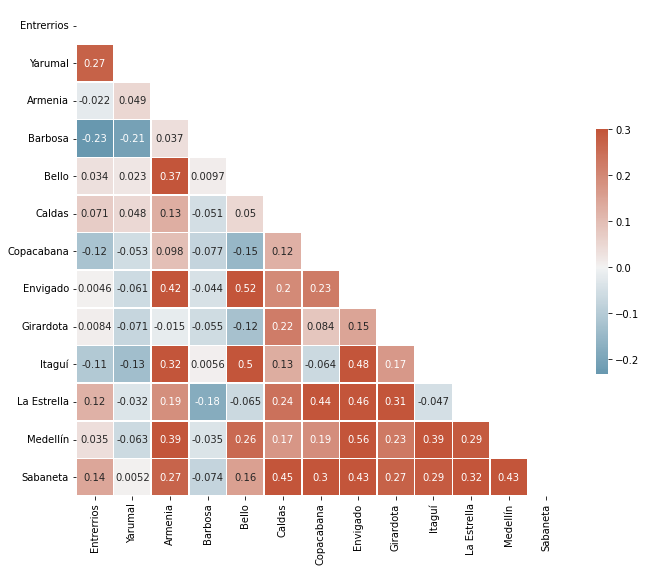

In [ ]:
# Generate a large random dataset

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [118]:
dd = df[["Date",'Envigado','Itaguí', 'Sabaneta', "Medellín"]]


dd_g = df_g[["Date",'Envigado','Itaguí', 'Sabaneta', "Medellín"]]
dd_g

,Date,Envigado,Itaguí,Sabaneta,Medellín
0,2020-08-31,9226.330383,8939.256734,7941.127873,11002.703477
1,2020-09-30,8877.348171,8329.184769,7839.260953,10759.134581
2,2020-10-31,9215.045376,8844.379161,7934.819613,12088.219158
3,2020-11-30,9063.933521,8188.328483,8342.357362,11564.990923
4,2020-12-31,9388.168906,8146.683301,8861.339047,11882.525905
5,2021-01-31,9548.313806,8348.271297,8946.330531,11799.567408
6,2021-02-28,9470.437052,8402.786697,8447.177135,11529.227159
7,2021-03-31,9658.600278,8781.633006,8733.596656,11502.166364


In [119]:
ACPM = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data_Eafit/acpm.csv")
acpm = ACPM[["date", "Medellín_acpm"]]
acpm = acpm.rename(columns={"date":"Date"})
acpm["Date"] = pd.to_datetime(acpm["Date"])

In [120]:
df_g = dd_g.merge(acpm,how="inner", on='Date')
df_g

,Date,Envigado,Itaguí,Sabaneta,Medellín,Medellín_acpm
0,2020-08-31,9226.330383,8939.256734,7941.127873,11002.703477,8503.0
1,2020-09-30,8877.348171,8329.184769,7839.260953,10759.134581,8524.0
2,2020-10-31,9215.045376,8844.379161,7934.819613,12088.219158,8476.0
3,2020-11-30,9063.933521,8188.328483,8342.357362,11564.990923,8479.0
4,2020-12-31,9388.168906,8146.683301,8861.339047,11882.525905,8544.0
5,2021-01-31,9548.313806,8348.271297,8946.330531,11799.567408,8564.0
6,2021-02-28,9470.437052,8402.786697,8447.177135,11529.227159,8688.0
7,2021-03-31,9658.600278,8781.633006,8733.596656,11502.166364,8820.0


In [58]:
class MyFitter:
    max_plate_nesting = 1  # max number of plates nested in model

    def __init__(self, data):
        for key, value in data.items():
            key = key.lower()
            if isinstance(value, (list, np.ndarray)):
                value = torch.tensor(value, dtype=torch.float)
            self.__dict__[key] = value

    def __call__(self):
        extra_out = {}
        
        p = self.regressor.shape[1]
        bias = pyro.sample("bias", dist.Normal(0, 1))
        weight = pyro.sample("weight", dist.Normal(0, 1).expand([p]).to_event(1))
        yhat = bias + weight @ self.regressor.transpose(-1, -2)
        obs_sigma = pyro.sample("obs_sigma", dist.HalfCauchy(self.response_sd))
        
        with pyro.plate("response_plate", self.num_of_obs):
            pyro.sample("response", dist.Normal(yhat, obs_sigma), obs=self.response)
        return extra_out


In [59]:
class BayesLinearRegression(ModelTemplate):
    _fitter = MyFitter
    _data_input_mapper = ['regressor']
    _supported_estimator_types = [PyroEstimatorVI]
    
    def __init__(self, regressor_col, **kwargs):
        super().__init__(**kwargs)
        self.regressor_col = regressor_col
        self.regressor = None
        self._model_param_names = ['bias', 'weight', 'obs_sigma']
        
    def set_dynamic_attributes(self, df, training_meta):  
        self.regressor = df[self.regressor_col].values
    
    def predict(self, posterior_estimates, df, training_meta, prediction_meta, include_error=False, **kwargs):
        model = deepcopy(posterior_estimates)
        new_regressor = df[self.regressor_col].values.T
        bias =  np.expand_dims(model.get('bias'),-1)
        obs_sigma = np.expand_dims(model.get('obs_sigma'), -1)
        weight = model.get('weight')
        
        pred_len = df.shape[0]
        batch_size = weight.shape[0]
        
        prediction = bias + np.matmul(weight, new_regressor) + \
            np.random.normal(0, obs_sigma, size=(batch_size, pred_len))
        return {'prediction': prediction}



In [122]:
test_size = 31
train_df = df[:-test_size]
test_df = df[-test_size:]


test_size_g = 1
train_df_g = df_g[:-test_size_g]
test_df_g = df_g[-test_size_g:]

In [149]:
model = BayesLinearRegression(
    regressor_col=['Envigado','Itaguí', 'Sabaneta'], 
)


model_g = BayesLinearRegression(
    regressor_col=['Envigado','Itaguí', 'Sabaneta', "Medellín_acpm"], 
)

In [150]:
blr = SVIForecaster(
    model=model,
    response_col='Medellín', 
    date_col='Date',
    estimator_type=PyroEstimatorVI,
    verbose=True,
    num_steps=501,
    seed=2021,
)
blr_g = SVIForecaster(
    model=model_g,
    response_col='Medellín', 
    date_col='Date',
    estimator_type=PyroEstimatorVI,
    verbose=True,
    num_steps=501,
    seed=2021,
)


In [151]:
blr

In [146]:
blr_g

In [162]:
blr.fit(train_df)

step    0 loss = 9.2299e+05, scale = 0.082326
step  100 loss = 1.6395e+05, scale = 0.40623
step  200 loss = 1.6664e+05, scale = 0.29808
step  300 loss = 1.6391e+05, scale = 0.44326
step  400 loss = 1.6651e+05, scale = 0.39401
step  500 loss = 1.668e+05, scale = 0.45152


In [163]:
blr_g.fit(train_df_g)

step    0 loss = 2.0889e+05, scale = 0.08566
step  100 loss = 5814.6, scale = 0.42156
step  200 loss = 5326.7, scale = 0.37432
step  300 loss = 6319.9, scale = 0.39831
step  400 loss = 5693.3, scale = 0.37532
step  500 loss = 5414.8, scale = 0.41242


In [164]:
# Save the model
filename = "blr_model"
pickle.dump(blr, open(filename, 'wb'))

# Load the model
loaded_model = pickle.load(open(filename, 'rb'))


# Save the model
filename_g = "blr_model_g"
pickle.dump(blr_g, open(filename_g, 'wb'))

# Load the model
loaded_model_g = pickle.load(open(filename, 'rb'))

In [165]:
x, y, coefs = make_regression(120, [3.0, -1.0], bias=1.0, scale=1.0)

In [166]:
estimated_weights = loaded_model.get_posterior_samples()['weight']
estimated_weights_g = loaded_model_g.get_posterior_samples()['weight']

In [167]:
print("True Coef: {:.3f}, {:.3f}".format(coefs[0], coefs[1]) )
estimated_coef = np.median(estimated_weights, axis=0)
print("Estimated Coef: {:.3f}, {:.3f}".format(estimated_coef[0], estimated_coef[1]))


print("True Coef: {:.3f}, {:.3f}".format(coefs[0], coefs[1]) )
estimated_coef_g = np.median(estimated_weights_g, axis=0)
print("Estimated Coef: {:.3f}, {:.3f}".format(estimated_coef[0], estimated_coef[1]))


True Coef: 3.000, -1.000
Estimated Coef: 0.430, 0.323
True Coef: 3.000, -1.000
Estimated Coef: 0.430, 0.323


In [168]:
predicted_df = blr.predict(df)
predicted_df_g = blr_g.predict(df_g)

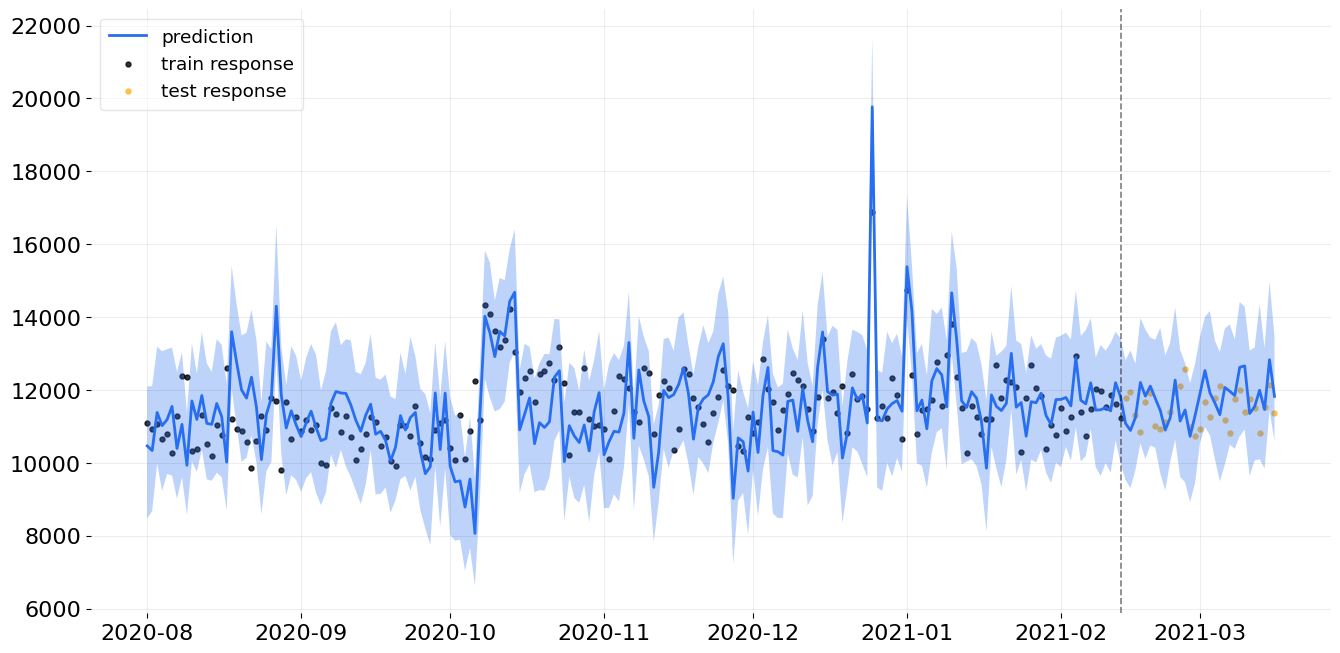

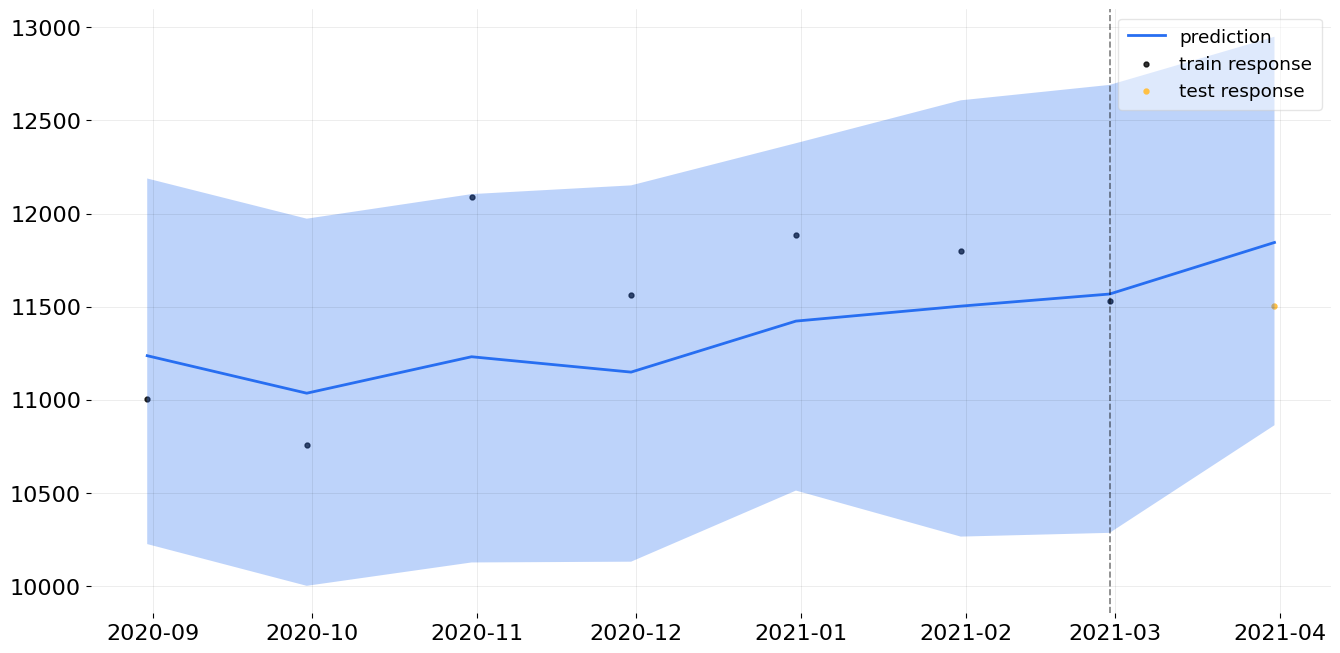

In [169]:
_ = plot_predicted_data(train_df, predicted_df, 
                        'Date', 'Medellín', 
                        test_actual_df=test_df, 
                        prediction_percentiles=[5, 95])

_ = plot_predicted_data(train_df_g, predicted_df_g, 
                        'Date', 'Medellín', 
                        test_actual_df=test_df_g, 
                        prediction_percentiles=[5, 95])

In [108]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



**Predicción de un mes sin usar precio acpm**

In [176]:
pd.concat([predicted_df[["Date", "prediction"]][-31:], test_df[["Medellín"]]], axis=1)

,Date,prediction,Medellín
197,2021-02-14,11086.381240,11772.745999
198,2021-02-15,10890.691177,11949.100869
199,2021-02-16,11246.409328,11312.397444
200,2021-02-17,12206.687883,10855.711309
201,2021-02-18,11831.315432,11683.590626
202,2021-02-19,12106.785538,11912.037931
203,2021-02-20,11769.244588,11014.806945
204,2021-02-21,11441.533089,10921.106605
205,2021-02-22,10900.372424,11123.631925
206,2021-02-23,11237.141585,11398.192246


In [172]:
mape = mean_absolute_percentage_error(test_df["Medellín"], predicted_df[["prediction"]][-31:])
print("MAPE: {:.3f}%".format(mape))

MAPE: 5.278%


**Predicción de un mes usando precio acpm**

In [177]:
pd.concat([predicted_df_g[["Date", "prediction"]][-1:], test_df_g[["Medellín"]]], axis=1)

,Date,prediction,Medellín
7,2021-03-31,11844.517755,11502.166364


In [175]:
mape_g = mean_absolute_percentage_error(test_df_g["Medellín"], predicted_df_g[["prediction"]][-1:])
print("MAPE: {:.3f}%".format(mape_g))

MAPE: 2.976%
